In [338]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [339]:
class Value:

    def __init__(self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __radd__(self, other): 
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only support int/float powers"

        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad

        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():

            self.grad += (1-out.data**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():

            self.grad += out.data * out.grad

        out._backward = _backward

        return out
        
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()


In [340]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):

        if v not in nodes:

            nodes.add(v)

            for child in v._prev:
                edges.add((child, v))
                build(child)
            build(v)
    
    build(root)

    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR: left to right 

    nodes, edges = trace(root)

    for n in nodes: 
        uid = str(id(n))
        #for any value in the graph, create a rectangular node for it
        dot.node(name=uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape ='record')

        if n._op:
            # if this value is a result of some opertation, create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op )
    
    return dot


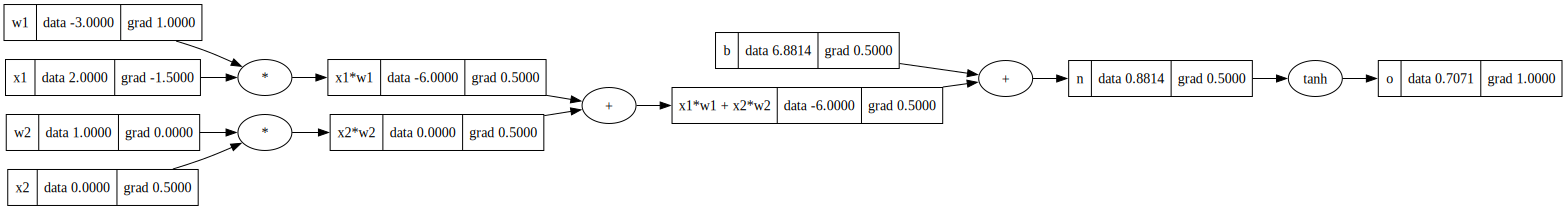

In [341]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias b
b = Value(6.881377, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1*w1 + x2*w2'
n = x1w1x2w2 +b; n.label = 'n'

o = n.tanh(); o.label='o'
o.backward()
draw_dot(o)


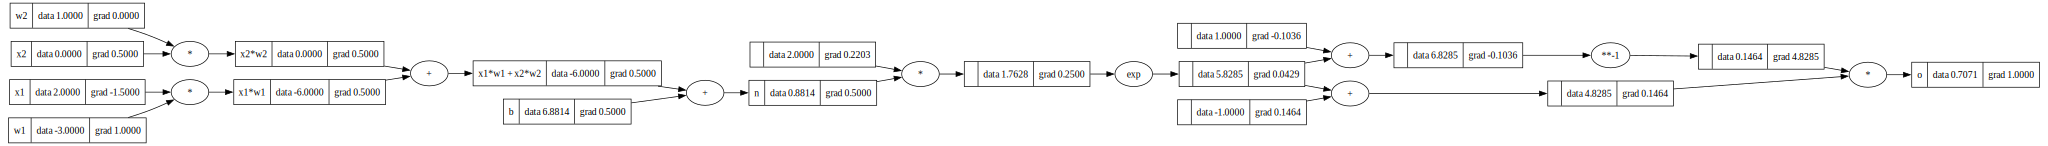

In [342]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias b
b = Value(6.881377, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1*w1 + x2*w2'
n = x1w1x2w2 +b; n.label = 'n'
#-------
e =(2*n).exp()
o = (e-1)/(e+1)
#-------
o.label='o'
o.backward()
draw_dot(o)



In [343]:
#check if torch results are the same
import torch


In [344]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.881377]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)


# o is dtype float64 since we cast it to double using .double()
print(o.data)
#.item() pops the value from the data
print(o.data.item())

try:
    print('Gradient of x1: ', x1.grad.item())
except:
    print('No gradient') # will fail as we have not called backwards
    
#calling the backwards pass gives the torches .grad
o.backward()

print('---')
print('Gradient of x1: ', x1.grad.item())
print('Gradient of w1: ', w1.grad.item())
print('Gradient of x2: ', w2.grad.item())
print('Gradient of w2: ', x2.grad.item())


tensor([0.7071], dtype=torch.float64)
0.7071085977490136
No gradient
---
Gradient of x1:  -1.4999922929682712
Gradient of w1:  0.9999948619788475
Gradient of x2:  0.0
Gradient of w2:  0.49999743098942373


In [345]:
# create neuron from our Value class
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        #w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]

        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]

    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return[p for layer in self.layers for p in layer.parameters()]


In [346]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=0.9285110186583153)

In [347]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


In [348]:
#mean squared error
loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
loss


Value(data=0.003365774814585747)

In [349]:
for k in range(200):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])
    

    #zer0 gradients
    for p in n.parameters():
        p.grad = 0.0
        
    #backwards pass
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)



0 6.81757504822327
1 6.681073587388489
2 6.515473864237699
3 6.312331818966454
4 6.060569444665742
5 5.7460839945111575
6 5.352155882395289
7 4.862159529123167
8 4.2673839794181525
9 3.5825746128768294
10 2.8632348473369507
11 2.1988491450319705
12 1.6638418889054825
13 1.2747225508784812
14 1.0040768426258562
15 0.8157676550057591
16 0.6817095037208449
17 0.5833532438831271
18 0.5089819508845683
19 0.4511778666184231
20 0.40514895068978
21 0.36771749931040454
22 0.33671878418457674
23 0.3106397517599043
24 0.28839743790654065
25 0.26919977479363033
26 0.2524559982183606
27 0.23771761214495224
28 0.22463862222118747
29 0.2129481961777748
30 0.2024315102898615
31 0.1929160960959221
32 0.18426195128860445
33 0.17635427087056088
34 0.16909803125257342
35 0.16241390393725302
36 0.15623513625579236
37 0.1505051443810314
38 0.1451756371453071
39 0.14020513977434482
40 0.13555782201927305
41 0.13120256021233476
42 0.1271121807115384
43 0.1232628451920578
44 0.11963354774941604
45 0.1162057008

In [350]:
ypred


[Value(data=0.9513375159026508),
 Value(data=-0.9265258786746929),
 Value(data=-0.917030859606029),
 Value(data=0.9301669176032425)]